In [1]:
%matplotlib inline
from rayoptics.environment import *
from rayoptics.raytr import sampler
import numpy as np
import os, vg

# Function definitions for the simulation

initializations specific to _ray-optics_ for a given setup. 

note that this implies a fixed (very simple) optical setup, it's the one discussed in: https://github.com/mjhoptics/ray-optics/discussions/45

In [2]:
def define_optics(lens_codv_name, detector_plane, aperture_stop, aoa_list):
    opm = open_model(lens_codv_name)
    sm  = opm.seq_model
    osp = opm.optical_spec
    pm = opm.parax_model

    sm.gaps[2].thi = detector_plane
    osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value = aperture_stop)
    sm.set_cur_surface(2) 
    sm.set_stop()
    
    osp.field_of_view = FieldSpec(osp, flds = aoa_list)

    opm.update_model()
    
    return opm, sm, osp, pm

tracing rays through the optical setup 

In [3]:
def get_ray_lists(num_rays_sqrt, limits, osp, opm, draw_spots=False):
    num_flds = len(osp.field_of_view.fields)

    # trace rays at each field and save results
    num_rays= num_rays_sqrt
    us = limits
    ray_lists = []
    on_axis_pt = np.array([0.0, 0.0])
    for f in range(num_flds):
        fld, wvl, foc = osp.lookup_fld_wvl_focus(f)

        r2g      = (sampler.create_generator, (sampler.R_2_quasi_random_generator, num_rays**2), dict(mapper=sampler.concentric_sample_disk))
        ray_lists += [analyses.RayList(opm, pupil_gen=r2g, f=fld, wl=wvl, image_pt_2d=on_axis_pt)]

    if(draw_spots):
        subplots = [RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d',
                              yaxis_ticks_position='right', cmap='gray',
                              title=f'{osp.field_of_view.fields[f].y} deg') for f, ray_list in enumerate(ray_lists)]

        # set up a figure and draw the irradiance maps into it
        irrdfig = plt.figure(FigureClass=AnalysisFigure, data_objs=ray_lists, subplots=subplots, grid=(1, num_flds),
                             figsize=[20, 10], dpi=150, tight_layout=True, is_dark=False).plot()
    
    return ray_lists

compute transmission coefficients through surfaces (used in fresnel loss computations)

In [4]:
def calc_transmission_coefs(ray_list, rndx, idx):
    raydirvec_front        = ray_list[idx][2][0][0][1];
    raydirvec_back         = ray_list[idx][2][0][1][1];
    raydirvec_out          = ray_list[idx][2][0][2][1];
    surfnormalvec_front    = ray_list[idx][2][0][1][3];
    surfnormalvec_back     = ray_list[idx][2][0][2][3];

    # vg.angle() -> https://stackoverflow.com/a/55517239
    # first surface, lens front (curved) 
    n1 = rndx[0][0]; #air
    n2 = rndx[1][0]; #lens
    ai = np.deg2rad(vg.angle(raydirvec_front, surfnormalvec_front)); # incidence angle
    at = np.deg2rad(vg.angle(raydirvec_back,  surfnormalvec_front)); # transmission angle
    R_s_polarized        = ((n1*np.cos(ai) - n2*np.cos(at))/(n1*np.cos(ai) + n2*np.cos(at)))**2;
    R_p_polarized        = ((n1*np.cos(at) - n2*np.cos(ai))/(n1*np.cos(at) + n2*np.cos(ai)))**2;
    R_effective          = (R_s_polarized + R_p_polarized)/2
    transmit_coef_front  = 1-R_effective

    # second surface, lens back (straight)
    n1 = rndx[1][0]; #lens
    n2 = rndx[2][0]; #air
    ai = np.deg2rad(vg.angle(raydirvec_back, surfnormalvec_back)); # incidence angle
    at = np.deg2rad(vg.angle(raydirvec_out,  surfnormalvec_back)); # transmission angle
    R_s_polarized        = ((n1*np.cos(ai) - n2*np.cos(at))/(n1*np.cos(ai) + n2*np.cos(at)))**2;
    R_p_polarized        = ((n1*np.cos(at) - n2*np.cos(ai))/(n1*np.cos(at) + n2*np.cos(ai)))**2;
    R_effective          = (R_s_polarized + R_p_polarized)/2
    transmit_coef_back   = 1-R_effective
    
    return [transmit_coef_front, transmit_coef_back]

compute angular response for the setup discussed in:
https://github.com/mjhoptics/ray-optics/discussions/45

i.e., a quad detector and a lens+aperture stop right above it

note that there is an option for taking the fresnel losses into account

In [5]:
def calc_angular_response(ray_list, rndx, with_fresnel=False):
    xy_of_rays_on_spot = np.zeros((1,2)) # [0]: x, [1]: y
    
    # this "index train" eventually gives: 
    #      xy position ( via [0][0:2]) 
    #      on the 4th surface ( via [3], due to 0-start-indexing )  
    #      for ray idx 0 ( via the first [0])
    #      and the [2][0] in the middle does not have physical meaning
    xy_of_rays_on_spot[0]  = ray_list[0][2][0][3][0][0:2];     
    for ray_idx in range(1,len(ray_list)):
        xy_of_rays_on_spot = np.concatenate((xy_of_rays_on_spot, 
                                             np.expand_dims(ray_list[ray_idx][2][0][3][0][0:2],axis=0)))
    x = xy_of_rays_on_spot[:,0];
    y = xy_of_rays_on_spot[:,1];
    
    # assuming a quadrant detector, size not limited
    qA_rays     = np.logical_and((x > 0),(y > 0))
    qB_rays     = np.logical_and((x < 0),(y > 0))
    qC_rays     = np.logical_and((x > 0),(y < 0))
    qD_rays     = np.logical_and((x < 0),(y < 0))
    qA_num_rays = np.count_nonzero( qA_rays )
    qB_num_rays = np.count_nonzero( qB_rays )
    qC_num_rays = np.count_nonzero( qC_rays )
    qD_num_rays = np.count_nonzero( qD_rays )

    # phi denotes the "power ratio" among quadrants
    # this is without fresnel losses
    total  = qA_num_rays + qB_num_rays + qC_num_rays + qD_num_rays
    phi_AC = ( (qA_num_rays + qC_num_rays) - (qB_num_rays + qD_num_rays) ) / total ;
    phi_AB = ( (qA_num_rays + qB_num_rays) - (qC_num_rays + qD_num_rays) ) / total ;

    # handle fresnel losses here
    phi_AB_wf = None
    phi_AC_wf = None
    if(with_fresnel):
        coefs_on_surfaces    = np.zeros((1,2)) # [0]: from lens front curved, [1]: from lens back straight 
        coefs_on_surfaces[0] = calc_transmission_coefs(ray_list, rndx, 0);
        
        for ray_idx in range(1,len(ray_list)):
            tt                = calc_transmission_coefs(ray_list, rndx, ray_idx);
            coefs_on_surfaces = np.concatenate((coefs_on_surfaces, np.expand_dims(tt,axis=0)))

        transmission_scaler = coefs_on_surfaces[:,0]*coefs_on_surfaces[:,1];
        qA_rays_weighted = np.sum(qA_rays.astype(np.float)*transmission_scaler)
        qB_rays_weighted = np.sum(qB_rays.astype(np.float)*transmission_scaler)
        qC_rays_weighted = np.sum(qC_rays.astype(np.float)*transmission_scaler)
        qD_rays_weighted = np.sum(qD_rays.astype(np.float)*transmission_scaler)
        
        # same as above, but this time with fresnel losses
        total     = qA_rays_weighted + qB_rays_weighted + qC_rays_weighted + qD_rays_weighted
        phi_AC_wf = ( (qA_rays_weighted + qC_rays_weighted) - (qB_rays_weighted + qD_rays_weighted) ) / total ;
        phi_AB_wf = ( (qA_rays_weighted + qB_rays_weighted) - (qC_rays_weighted + qD_rays_weighted) ) / total ;

    return phi_AB, phi_AC, phi_AB_wf, phi_AC_wf, total

just a wrapper for the fcn above

In [6]:
def calc_fqrx(osp, raylist, aoa_list, rndx, draw_fqrx=False, with_fresnel=False):
    num_flds = len(osp.field_of_view.fields)
    phi_AB_list    = []
    phi_AB_wf_list = []
    total_list = []
    for i in range(0, num_flds):
        ray_list_for_aoa = raylist[i].ray_list;
        
        # just compute the horizontal response, that's enough, system is radially symmetric, so drop ACs
        phi_AB, _, phi_AB_wf, _, total = calc_angular_response(ray_list_for_aoa, rndx, with_fresnel=with_fresnel)
        phi_AB_list.append(phi_AB)
        if(with_fresnel):
            phi_AB_wf_list.append(phi_AB_wf)
        total_list.append(total)

    if(draw_fqrx):
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(aoa_list, phi_AB_list)
        if(with_fresnel):
            ax.plot(aoa_list, phi_AB_wf_list)
            ax.legend(['without Fresnel losses', 'with Fresnel losses'])
        ax.set_xlim([-90, 90])
        ax.set_ylim([-1.1, 1.1])
        plt.show()
    return phi_AB_list, phi_AB_wf_list, total_list

# Optical setups + simulations

both setups here consider a quad detector and a lens+aperture stop above, the lens properties and the stop size changes

### with a hemispherical Lens

we expect fresnel losses to be significant here since incidence angles will be large for a hemispherical lens 

             r            t        medium     mode   zdr      sd
 Obj:     0.000000  1.00000e+13       air             1  8.3910e+12
45936:     4.000000      4.00000       BK7             1      4.0000
Stop:     0.000000     0.550000       air             1      4.0000
 Img:     0.000000      0.00000                       1      1.0000


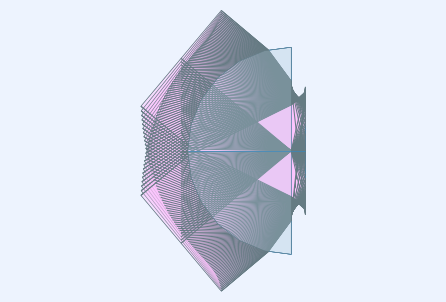

In [7]:
## 8.0mm Diameter, N-BK7 Half-Ball Lens
lens_codv_name = "CODV_45936.seq"
if (not os.path.isfile(lens_codv_name)):
    print('File', lens_codv_name, 'does not exist, downloading from EdmundOptics website')
    cmd = 'wget https://www.edmundoptics.com/document/download/471193 -O ' + lens_codv_name
    os.system(cmd)
aperture_stop    = 6.3  # d_H
detector_plane   = 0.55 # d_X
aoa_sweep_lim    = 40.0
aoa_sweep_res    = 1.0
aoa_list         = np.arange(-aoa_sweep_lim, aoa_sweep_lim + aoa_sweep_res, aoa_sweep_res).tolist()

opm, sm, osp, pm = define_optics(lens_codv_name, detector_plane, aperture_stop, aoa_list)

sm.list_model()
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_rays=True, do_paraxial_layout=False).plot()

In [8]:
rl = get_ray_lists(40, 4, osp, opm, draw_spots=False)

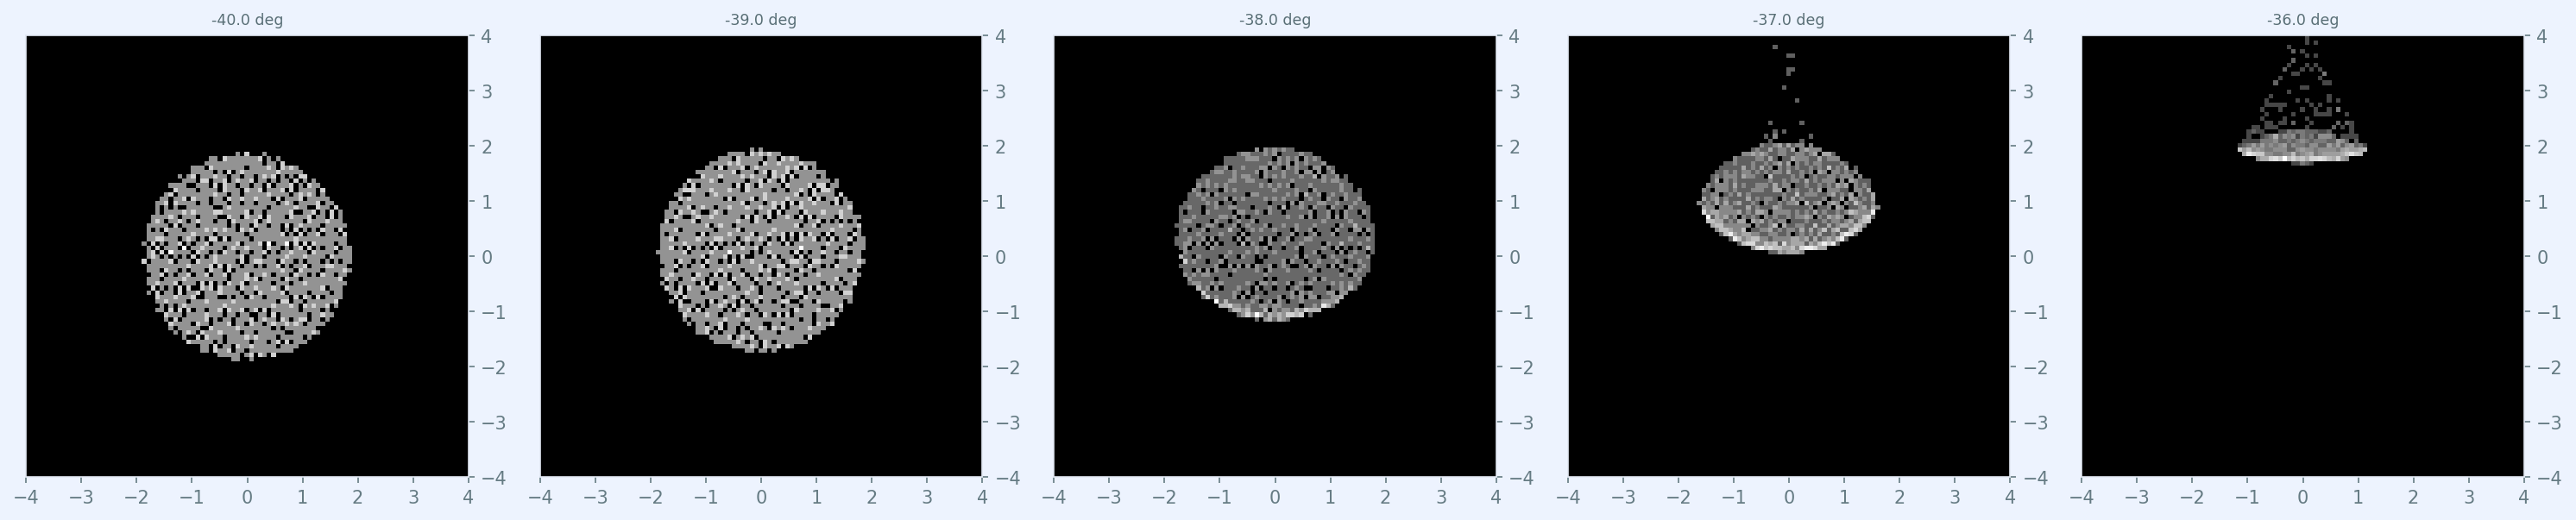

In [9]:
us = 4
subplots = [RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d',
                      yaxis_ticks_position='right', cmap='gray',
                      title=f'{osp.field_of_view.fields[f].y} deg') for f, ray_list in enumerate(rl[40:81:10])]

# set up a figure and draw the irradiance maps into it
irrdfig = plt.figure(FigureClass=AnalysisFigure, data_objs=rl, subplots=subplots, grid=(1, len(subplots)),
                     figsize=[20, 10], dpi=150, tight_layout=True, is_dark=False).plot()

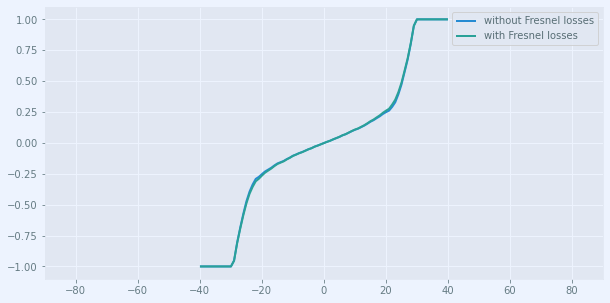

In [10]:
a, b, total = calc_fqrx(osp, rl, aoa_list, sm.rndx, with_fresnel=True, draw_fqrx=True)

In [11]:
print("difference between response w/ and w/o fresnel losses: \n\n", 
      np.round(1000*100*np.mean(np.divide(np.asarray(a)-np.asarray(b), np.asarray(a))))/1000, '%')

difference between response w/ and w/o fresnel losses: 

 -1.831 %


the effect isn't exactly huge, but probably it will be higher than the next example

### PlanoConvex Lens, f=90.0mm

             r            t        medium     mode   zdr      sd
 Obj:     0.000000  1.00000e+13       air             1  1.8807e+13
67149:    46.510000      2.00000     N-BK7             1      4.0500
Stop:     0.000000      1.00000       air             1      3.7258
 Img:     0.000000      0.00000                       1      3.8315


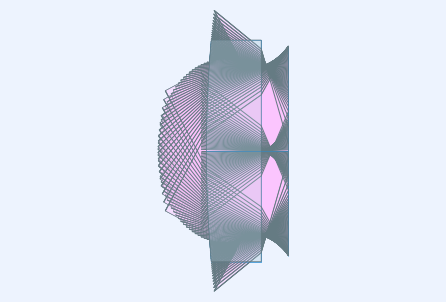

In [12]:
## 9.0mm Dia. x 90.0mm FL, Uncoated, Plano-Convex Lens
lens_codv_name = "CODV_67149.seq"
if (not os.path.isfile(lens_codv_name)):
    print('File', lens_codv_name, 'does not exist, downloading from EdmundOptics website')
    cmd = 'wget https://www.edmundoptics.com/document/download/474580 -O ' + lens_codv_name
    os.system(cmd)
aperture_stop    = 6.3  # d_H
detector_plane   = 1.0 # d_X
aoa_sweep_lim    = 62.0
aoa_sweep_res    = 2.0
aoa_list         = np.arange(-aoa_sweep_lim, aoa_sweep_lim + aoa_sweep_res, aoa_sweep_res).tolist()

opm, sm, osp, pm = define_optics(lens_codv_name, detector_plane, aperture_stop, aoa_list)

sm.list_model()
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_rays=True, do_paraxial_layout=False).plot()

In [13]:
rl = get_ray_lists(40, 4, osp, opm, draw_spots=False)

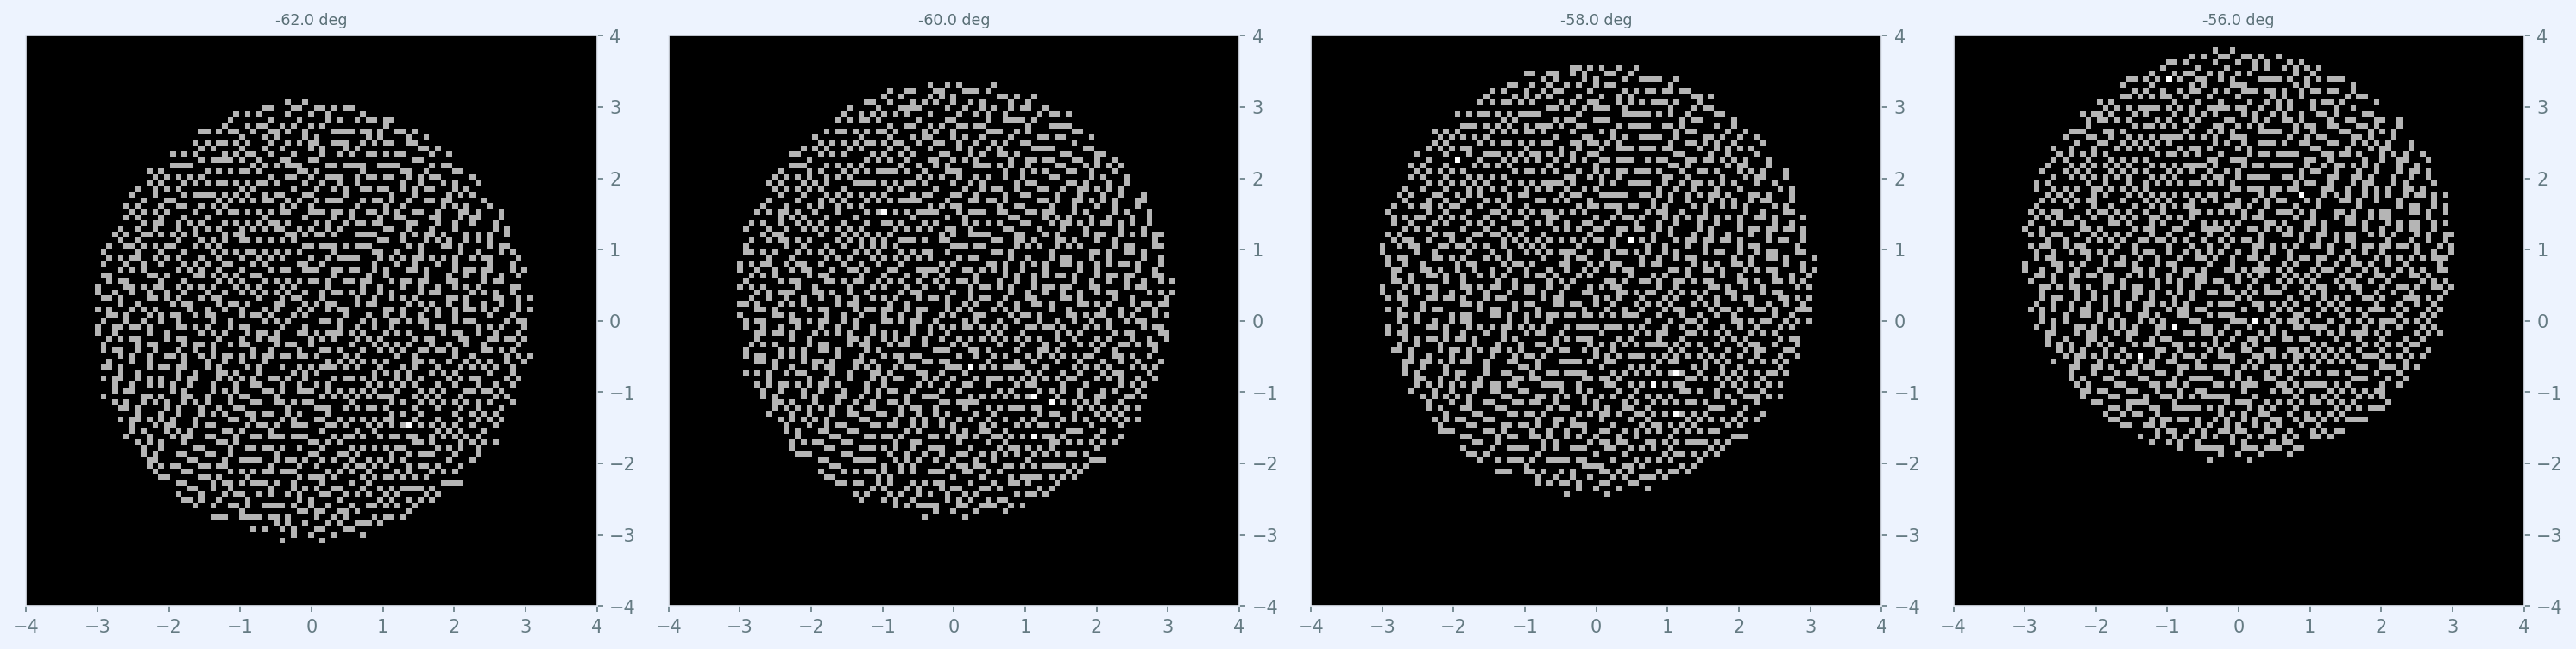

In [14]:
us = 4
subplots = [RayGeoPSF(ray_list, user_scale_value=us, scale_type='user', dsp_typ='hist2d',
                      yaxis_ticks_position='right', cmap='gray',
                      title=f'{osp.field_of_view.fields[f].y} deg') for f, ray_list in enumerate(rl[31:63:8])]

# set up a figure and draw the irradiance maps into it
irrdfig = plt.figure(FigureClass=AnalysisFigure, data_objs=rl, subplots=subplots, grid=(1, len(subplots)),
                     figsize=[20, 10], dpi=150, tight_layout=True, is_dark=False).plot()

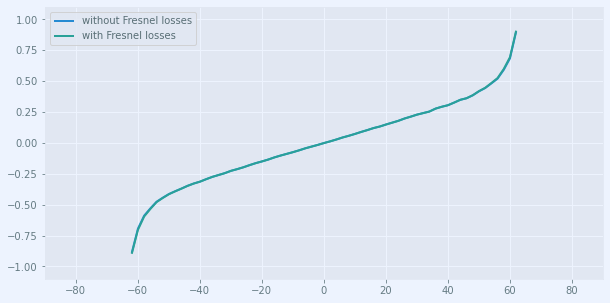

In [15]:
a, b, total = calc_fqrx(osp, rl, aoa_list, sm.rndx, with_fresnel=True, draw_fqrx=True)

In [16]:
print("difference between response w/ and w/o fresnel losses: \n\n", 
      np.round(1000*100*np.mean(np.divide(np.asarray(a)-np.asarray(b), np.asarray(a))))/1000, '%')

difference between response w/ and w/o fresnel losses: 

 -0.198 %


this is much lower than the hemispherical case since the incidence angles are lower here

### Plano parallel plate

In [17]:
def calc_reflection_coefs(ray, rndx):
    raydirvec_front        = ray[0][0][1];
    raydirvec_back         = ray[0][1][1];
    raydirvec_out          = ray[0][2][1];
    surfnormalvec_front    = ray[0][1][3];
    surfnormalvec_back     = ray[0][2][3];

    # first surface, lens front (curved) 
    n1 = rndx[0][0]; #air
    n2 = rndx[1][0]; #lens
    # use dot product for cosine. direction and normal vectors are already normalized
    cos_ai = np.dot(raydirvec_front, surfnormalvec_front)
    cos_at = np.dot(raydirvec_back, surfnormalvec_front)
    R_s_polarized        = ((n1*cos_ai - n2*cos_at)/(n1*cos_ai + n2*cos_at))**2;
    R_p_polarized        = ((n1*cos_at - n2*cos_ai)/(n1*cos_at + n2*cos_ai))**2;
    R_effective          = (R_s_polarized + R_p_polarized)/2
    R_front = R_s_polarized, R_p_polarized, R_effective
    transmit_coef_front  = 1-R_effective

    # second surface, lens back (straight)
    n1 = rndx[1][0]; #lens
    n2 = rndx[2][0]; #air
    cos_ai = np.dot(raydirvec_back, surfnormalvec_back)
    cos_at = np.dot(raydirvec_out, surfnormalvec_back)
    R_s_polarized        = ((n1*cos_ai - n2*cos_at)/(n1*cos_ai + n2*cos_at))**2;
    R_p_polarized        = ((n1*cos_at - n2*cos_ai)/(n1*cos_at + n2*cos_ai))**2;
    R_effective          = (R_s_polarized + R_p_polarized)/2
    R_back = R_s_polarized, R_p_polarized, R_effective
    transmit_coef_back   = 1-R_effective
    
    return R_front, R_back

In [18]:
def list_ray(ray_obj, tfrms=None, start=0):
    """ pretty print a ray either in local or global coordinates """
    if isinstance(ray_obj, tuple):
        ray = ray_obj[0]
    else:
        ray = ray_obj

    colHeader = "            L            M            N           SN_L" \
                "         SN_M         SN_N"
    print(colHeader)

    colFormats = "{:3d}: {:12.6f} {:12.6f} {:12.6g} {:12.6f} {:12.6f} " \
                 "{:12.6f}"

    for i, r in enumerate(ray[start:], start=start):
        if tfrms is None:
            print(colFormats.format(i,
                                    r[mc.d][0], r[mc.d][1], r[mc.d][2],
                                    r[mc.nrml][0], r[mc.nrml][1], r[mc.nrml][2],
                                    r[mc.dst]))
        else:
            rot, trns = tfrms[i]
            p = rot.dot(r[mc.p]) + trns
            d = rot.dot(r[mc.d])
            print(colFormats.format(i, p[0], p[1], p[2], d[0], d[1], d[2],
                                    r[mc.dst]))


In [19]:
opm = OpticalModel()
sm = opm['sm']
osp = opm['osp']

In [20]:
sm.gaps[0].thi = 1e10
opm.add_lens(power=0., th=.1, med=create_glass('N-BK7,Schott'))

In [21]:
aperture_stop    = 6.3  # d_H
detector_plane   = 1.0 # d_X

In [22]:
sm.gaps[2].thi = detector_plane
osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value = aperture_stop)
osp['fov'].set_from_list([0, 30, 56.6038])
sm.set_cur_surface(1) 
sm.set_stop()
opm.update_model()

In [23]:
sm.list_model()

             c            t        medium     mode   zdr      sd
 Obj:     0.000000  1.00000e+10       air             1  1.5168e+10
Stop:    -0.000000     0.100000     N-BK7             1      3.1500
   2:     0.000000      1.00000       air             1      3.2159
 Img:     0.000000      0.00000                       1      4.7327


In [24]:
sm.rndx

[[1.0], [1.5168000345005885], [1.0]]

In [25]:
rs_list = []
rp_list = []
ravg_list = []
pt = np.array([0., 0., 0.])
angles = range(0, 91, 1)
for i, angle in enumerate(angles):
    angle_rad = np.deg2rad(angle)
    dir_cos = np.array([0, np.sin(angle_rad), np.cos(angle_rad)])
    fld = rayoptics.raytr.opticalspec.Field(y=angle)
    ray_pkg = trace_base(opm, [0., 0.], fld, get_wavelength('d'))
    list_ray(ray_pkg)
    R_front, R_back = calc_reflection_coefs(ray_pkg, sm.rndx)
    rs, rp, ravg = R_front
    rs_list.append(rs)
    rp_list.append(rp)
    ravg_list.append(ravg)

            L            M            N           SN_L         SN_M         SN_N
  0:     0.000000     0.000000            1    -0.000000    -0.000000     1.000000
  1:     0.000000     0.000000            1     0.000000     0.000000     1.000000
  2:     0.000000     0.000000            1    -0.000000    -0.000000     1.000000
  3:     0.000000     0.000000            1    -0.000000    -0.000000     1.000000
            L            M            N           SN_L         SN_M         SN_N
  0:     0.000000     0.017452     0.999848    -0.000000     0.000000     1.000000
  1:     0.000000     0.011506     0.999934     0.000000     0.000000     1.000000
  2:     0.000000     0.017452     0.999848    -0.000000    -0.000000     1.000000
  3:     0.000000     0.017452     0.999848    -0.000000    -0.000000     1.000000
            L            M            N           SN_L         SN_M         SN_N
  0:     0.000000     0.034899     0.999391    -0.000000     0.000000     1.000000
  1:     0

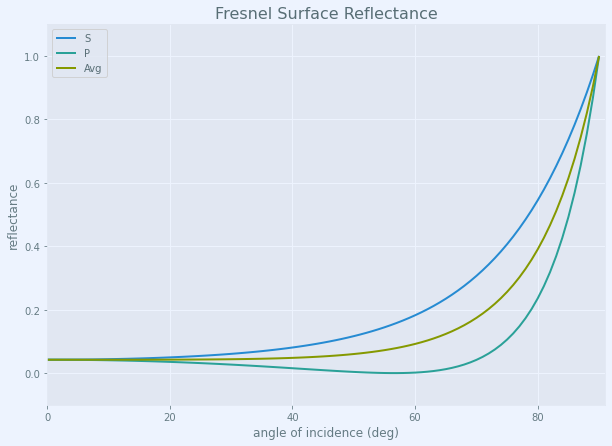

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(angles, rs_list)
ax.plot(angles, rp_list)
ax.plot(angles, ravg_list)
ax.set_xlim([0, 91])
ax.set_ylim([-0.1, 1.1])
ax.set_title('Fresnel Surface Reflectance')
ax.set_xlabel('angle of incidence (deg)')
ax.set_ylabel('reflectance')
ax.legend(['S', 'P', 'Avg'])
plt.show()

In [27]:
aoa_list = np.arange(-aoa_sweep_lim, aoa_sweep_lim + aoa_sweep_res, aoa_sweep_res).tolist()
osp['fov'].set_from_list(aoa_list)
opm.update_model()

In [28]:
rl = get_ray_lists(40, 4, osp, opm, draw_spots=False)

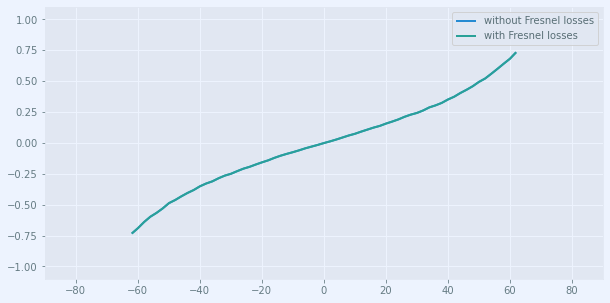

In [29]:
a, b, total = calc_fqrx(osp, rl, aoa_list, sm.rndx, with_fresnel=True, draw_fqrx=True)

In [30]:
print("difference between response w/ and w/o fresnel losses: \n\n", 
      np.round(1000*100*np.mean(np.divide(np.asarray(a)-np.asarray(b), np.asarray(a))))/1000, '%')

difference between response w/ and w/o fresnel losses: 

 0.0 %


this is much lower than the hemispherical case since the incidence angles are lower here